#### 모듈과 라이브러리

In [4]:
from selenium import webdriver
from time import sleep
from selenium.webdriver.common.by import By
from mecab import MeCab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.lda_model
import pandas as pd
import re

### 크롤링 함수

In [5]:
def page(url):
    driver.get(url)
    xp = 'span.product-tab-review-count'
    sleep(2)
    rb = driver.find_element(By.CSS_SELECTOR, xp)
    rb.click()

In [6]:
def review(n):
    texts = []
    for _ in range(n):
        for i in range(1, 11):
            pag = driver.find_elements(By.XPATH, '//*[@id="btfTab"]/ul[2]/li[3]/div/div[6]/section[4]/div[3]/button')
            pag_bnt = pag[i]
            pag_bnt.click()
            sleep(10)
            j = 1
            while j <= 5:
                x = len(driver.find_elements(By.XPATH, f'//*[@id="btfTab"]/ul[2]/li[3]/div/div[6]/section[4]/article[{j}]/div'))
                if x == 6:
                    text = driver.find_element(By.XPATH, f'//*[@id="btfTab"]/ul[2]/li[3]/div/div[6]/section[4]/article[{j}]/div[4]').get_attribute('innerText')
                    texts.append(text)
                    j += 1
    
                else:
                    text = driver.find_element(By.XPATH, f'//*[@id="btfTab"]/ul[2]/li[3]/div/div[6]/section[4]/article[{j}]/div[3]').get_attribute('innerText')
                    texts.append(text)
                    j += 1
    
        but = driver.find_element(By.CSS_SELECTOR, 'button.sdp-review__article__page__next.sdp-review__article__page__next--active.js_reviewArticlePageNextBtn')
        but.click()
        sleep(5)
    return texts

### 전처리 및 시각화 함수

In [7]:
def prehandle(df, stop_word):
    text_sub = []
    for text in df['0']:
        rtext = str(text).strip()
        rtext = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\xa0\n]', '', rtext)
        
        sptext = rtext.split(' ')
        nw = [w for w in sptext if w not in stop_word]
        rtext = ' '.join(nw)
        text_sub.append(rtext)
    df['text_sub'] = text_sub
    return df

<>:5: DeprecationWarning: invalid escape sequence '\?'
<>:5: DeprecationWarning: invalid escape sequence '\?'
C:\Users\user\AppData\Local\Temp\ipykernel_16036\3250383680.py:5: DeprecationWarning: invalid escape sequence '\?'
  rtext = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\xa0\n]', '', rtext)


In [8]:
def morpheme(df, use_tags):
    mecab = MeCab()
    rtexts = []
    
    for text in df['text_sub']:
        words = mecab.pos(text)
        words = [w[0] for w in words if w[1] in use_tags]
        rnew_text = ' '.join(words)
        rtexts.append(rnew_text)
    df['clean'] = rtexts
    return df

In [94]:
def tfvec(df, max, min):
    tfvec = TfidfVectorizer(max_df= max, min_df=min, token_pattern = r'(?u)\b\w{2,}\b')
    tfvec.fit(df['clean']) 
    names = tfvec.get_feature_names_out()

    x = tfvec.transform(df.loc[:, 'clean'])
    X = x.toarray()

    return tfvec, x, X, names

In [125]:
def cvec(df, max, min):
    cvec = CountVectorizer(max_df = 5, min_df=2, token_pattern = r'(?u)\b\w{2,}\b')
    cvec.fit(df['clean'])
    names = cvec.get_feature_names_out()
    
    x = cvec.transform(df.loc[:, 'clean'])
    X = x.toarray()

    return cvec, x, X, names

In [100]:
def makeBar(X, title, names):
    xsum = np.sum(X, axis=0)
    most_n = []
    most_v = []
    
    for ind in np.argsort(xsum)[-10:]: 
        most_n.append(names[ind]) 
        most_v.append(xsum[ind])

    plt.rc('font', family='Malgun Gothic')

    fcolor = '#212121'
    gcolor = '#616161'

    ax = plt.subplot()
    bars = ax.bar(most_n, most_v, width=0.7, color=gcolor)
    ax.set_title(title, fontsize=20)
    ax.tick_params(axis='both', labelsize=10, labelcolor=fcolor) 
    
    plt.show()

In [101]:
def LDA(x, vect, n_components, max_iter, l_m = 'online', r_s= 1):
    model = LatentDirichletAllocation(n_components = n_components, max_iter = max_iter,
                                  learning_method = l_m, random_state = r_s)

    model.fit(x)
    pyLDAvis.enable_notebook()
    pl = pyLDAvis.lda_model.prepare(model, x, vect)

    return pl

In [102]:
def makeWordcloud(df, title, stop_word):
    wc = WordCloud(font_path='./gulim.ttc',
                 background_color="white", 
                 collocations=False, 
                 width=800,                
                 height=800,
                 include_numbers = True,
                 stopwords = stop_word,
                 min_word_length = 2)                  

    wc.generate(' '.join(df['clean'].to_numpy()))
    plt.figure(figsize=(5,5))
    plt.rc('font', family='Malgun Gothic')
    ax = plt.subplot()
    ax.imshow(wc) 

    for i in 'top bottom right left'.split():
        ax.spines[i].set_visible(False)
        
    ax.set_title(title, fontsize=20)
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
    plt.show()

### 쿠팡_갤럭시 워치

In [ ]:
# 갤럭시워치 쿠팡 사이트 리스트 (워치 5, 워치 5 pro, 워치 6 클래식, 워치 6) 

g_list = ['https://www.coupang.com/vp/products/6675441423?itemId=15374275325&vendorItemId=82594371815&q=%EC%95%A0%ED%94%8C%EC%9B%8C%EC%B9%98&itemsCount=36&searchId=5da65911f5cf4e67938f1c8896de34f5&rank=3&isAddedCart=',
          'https://www.coupang.com/vp/products/6675441617?itemId=15374275335&vendorItemId=82594371829&q=%EA%B0%A4%EB%9F%AD%EC%8B%9C+%EC%9B%8C%EC%B9%98&itemsCount=36&searchId=e3be14b3b8794206b266895f780adc61&rank=10&isAddedCart=',
          'https://www.coupang.com/vp/products/7405993236?itemId=19178499550&vendorItemId=86296432392&q=%EA%B0%A4%EB%9F%AD%EC%8B%9C+%EC%9B%8C%EC%B9%98&itemsCount=36&searchId=a6a5e2aa694a4698adfd3c145ba913da&rank=7&isAddedCart=',
          'https://www.coupang.com/vp/products/7405993243?itemId=20078563745&vendorItemId=86296432531&q=%EA%B0%A4%EB%9F%AD%EC%8B%9C+%EC%9B%8C%EC%B9%98&itemsCount=36&searchId=e3be14b3b8794206b266895f780adc61&rank=0&isAddedCart=']

text_list = []
driver = webdriver.Chrome()

for i in range(len(g_list)):
    url = g_list[i]
    page(url)
    sleep(10)
    text_list.append(review(7))

In [ ]:
# 데이터프레임으로 저장
text_list = np.concatenate(text_list).tolist()
df_galaxy = pd.DataFrame(text_list)
df_galaxy.to_csv('./data/galaxy.csv', index=False)
df_galaxy

In [103]:
# 데이터프레임 읽어오기
df_galaxy = pd.read_csv('./data/galaxy.csv')
df_galaxy

,0
0,<구매배경>\n어무니가 일하실 때 스마트 워치를 써보고 싶다고 하셔서 찾아보다가 갤...
1,✅ 구매이유 : 아빠 선물해 드리려고 구매 했어요 일 하시\n면서 시계를 자주 봐야...
2,✔ ✔ 추 가 후 기 ✔ ✔\n부모님께서 사용하시면서 삶의 질이 올라가신게\n확실히...
3,✔ 내돈내산의 주관적인 리뷰임을 알려드립니다. ✔\n\n✅제품명 : 삼성 갤럭시워치...
4,⭐️내 돈 내산 솔직후기입니다⭐️\n\n사업과 영업을 하는 사람으로서 전화나 카톡 ...
...,...
1395,근데 이거 충전을못하는건가요??단자가 안맞습니다ㅜㅜ
1396,아이. 생일 선물로 잘 구입한거 같아용
1397,좋아요
1398,잘쓰고있습니다!


In [104]:
stop_word = ['','이','등', '좋', '워치', '갤럭시', '기능', '구매', '너무', '사용', '정도', '시계']
prehandle(df_galaxy, stop_word)

,0,text_sub
0,<구매배경>\n어무니가 일하실 때 스마트 워치를 써보고 싶다고 하셔서 찾아보다가 갤...,구매배경어무니가 일하실 때 스마트 워치를 써보고 싶다고 하셔서 찾아보다가 5가 좋은...
1,✅ 구매이유 : 아빠 선물해 드리려고 구매 했어요 일 하시\n면서 시계를 자주 봐야...,✅ 구매이유 아빠 선물해 드리려고 했어요 일 하시면서 시계를 자주 봐야 하는데 그때...
2,✔ ✔ 추 가 후 기 ✔ ✔\n부모님께서 사용하시면서 삶의 질이 올라가신게\n확실히...,✔ ✔ 추 가 후 기 ✔ ✔부모님께서 사용하시면서 삶의 질이 올라가신게확실히 전자기...
3,✔ 내돈내산의 주관적인 리뷰임을 알려드립니다. ✔\n\n✅제품명 : 삼성 갤럭시워치...,✔ 내돈내산의 주관적인 리뷰임을 알려드립니다 ✔✅제품명 삼성 갤럭시워치5 실버 40...
4,⭐️내 돈 내산 솔직후기입니다⭐️\n\n사업과 영업을 하는 사람으로서 전화나 카톡 ...,⭐️내 돈 내산 솔직후기입니다⭐️사업과 영업을 하는 사람으로서 전화나 카톡 문자들을...
...,...,...
1395,근데 이거 충전을못하는건가요??단자가 안맞습니다ㅜㅜ,근데 이거 충전을못하는건가요단자가 안맞습니다ㅜㅜ
1396,아이. 생일 선물로 잘 구입한거 같아용,아이 생일 선물로 잘 구입한거 같아용
1397,좋아요,좋아요
1398,잘쓰고있습니다!,잘쓰고있습니다


In [105]:
use_tags = ['NNP', 'NNG', 'NNB', 'NP', 'VA', 'VV', 'MAG']
morpheme(df_galaxy, use_tags)

,0,text_sub,clean
0,<구매배경>\n어무니가 일하실 때 스마트 워치를 써보고 싶다고 하셔서 찾아보다가 갤...,구매배경어무니가 일하실 때 스마트 워치를 써보고 싶다고 하셔서 찾아보다가 5가 좋은...,구매 배경 무니 일 때 스마트 워치 찾아보 좋 가격 구매 되 저 워치 선물 받 사용...
1,✅ 구매이유 : 아빠 선물해 드리려고 구매 했어요 일 하시\n면서 시계를 자주 봐야...,✅ 구매이유 아빠 선물해 드리려고 했어요 일 하시면서 시계를 자주 봐야 하는데 그때...,구매 이유 아빠 선물 하 시계 자주 하 그때 마다 핸드폰 꺼내 이제 날 손 시렵 카...
2,✔ ✔ 추 가 후 기 ✔ ✔\n부모님께서 사용하시면서 삶의 질이 올라가신게\n확실히...,✔ ✔ 추 가 후 기 ✔ ✔부모님께서 사용하시면서 삶의 질이 올라가신게확실히 전자기...,추 후 기 부모 사용 삶 질 올라가 확실히 전자 기기 분 손쉽 수 있 워치 효과 톡...
3,✔ 내돈내산의 주관적인 리뷰임을 알려드립니다. ✔\n\n✅제품명 : 삼성 갤럭시워치...,✔ 내돈내산의 주관적인 리뷰임을 알려드립니다 ✔✅제품명 삼성 갤럭시워치5 실버 40...,돈 내산 주관 리뷰 품명 삼성 갤럭시 워치 실버 블루투스 삼성 워치 돈 내산 구매 ...
4,⭐️내 돈 내산 솔직후기입니다⭐️\n\n사업과 영업을 하는 사람으로서 전화나 카톡 ...,⭐️내 돈 내산 솔직후기입니다⭐️사업과 영업을 하는 사람으로서 전화나 카톡 문자들을...,돈 내산 후기 사업 영업 하 사람 전화 카톡 문자 수시로 확인 되 중요 빠르 확인 ...
...,...,...,...
1395,근데 이거 충전을못하는건가요??단자가 안맞습니다ㅜㅜ,근데 이거 충전을못하는건가요단자가 안맞습니다ㅜㅜ,이거 충전 못 하 단자 안 맞
1396,아이. 생일 선물로 잘 구입한거 같아용,아이 생일 선물로 잘 구입한거 같아용,생일 선물 잘 구입 거 같
1397,좋아요,좋아요,좋
1398,잘쓰고있습니다!,잘쓰고있습니다,잘 쓰


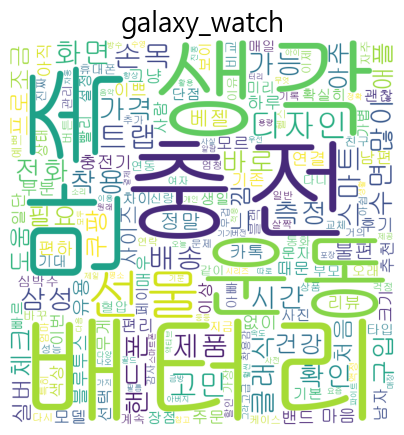

In [106]:
wc_galaxy = makeWordcloud(df_galaxy, 'galaxy_watch', stop_word)
wc_galaxy

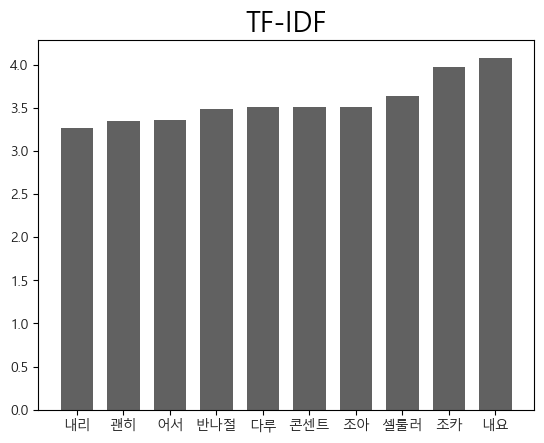

In [107]:
tfvec_tuple = tfvec(df_galaxy, 5, 2)
makeBar(tfvec_tuple[2], 'TF-IDF', tfvec_tuple[3])

In [111]:
pl_galaxy_tfvec = LDA(tfvec_tuple[1], tfvec_tuple[0], 3, 10)
pyLDAvis.save_html(pl_galaxy_tfvec, './model/lda_galaxy_tfvec.html')
pyLDAvis.display(pl_galaxy_tfvec)

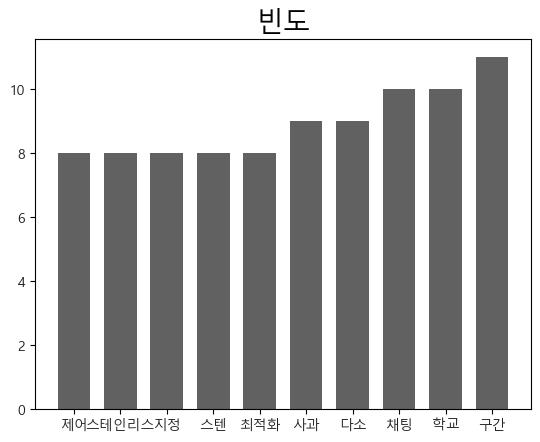

In [126]:
cvec_tuple = cvec(df_galaxy, 5, 2)
makeBar(cvec_tuple[2], '빈도', cvec_tuple[3])

In [127]:
pl_galaxy_cvec = LDA(cvec_tuple[1], cvec_tuple[0], 3, 10)
pyLDAvis.save_html(pl_galaxy_cvec, './model/lda_galaxy_cvec.html')
pyLDAvis.display(pl_galaxy_cvec)

### 쿠팡_애플워치

In [122]:
# 애플워치 쿠팡 사이트 리스트 (SE2, 워치 8, 워치 9 pro, 워치 6 클래식, 워치 6) 
a_list = ['https://www.coupang.com/vp/products/2128457892?itemId=11356736074&vendorItemId=81166203861&q=%EC%95%A0%ED%94%8C%EC%9B%8C%EC%B9%98+se&itemsCount=36&searchId=73529d2df91b49ab96115230bc5e04c9&rank=43&isAddedCart=',
          'https://www.coupang.com/vp/products/7606087908?itemId=20132572925&vendorItemId=87226505482&q=%EC%95%A0%ED%94%8C%EC%9B%8C%EC%B9%98&itemsCount=36&searchId=5da65911f5cf4e67938f1c8896de34f5&rank=0&isAddedCart=',
          'https://www.coupang.com/vp/products/7232722643?itemId=15997175940&vendorItemId=87991478273&q=%EC%95%A0%ED%94%8C%EC%9B%8C%EC%B9%987&itemsCount=36&searchId=c4a0b38690a04f34880c49b413eafb2b&rank=7&isAddedCart=',
          'https://www.coupang.com/vp/products/7630892228?itemId=20252617613&vendorItemId=87340572647&q=%EC%95%A0%ED%94%8C%EC%9B%8C%EC%B9%98+6&itemsCount=36&searchId=e96459f1df9f4e86a6133f9a2d93c53f&rank=6&isAddedCart=']

text_list = []
driver = webdriver.Chrome()

for i in range(len(g_list)):
    url = a_list[i]
    page(url)
    sleep(3)
    text_list.append(review(7))

NameError: name 'g_list' is not defined

In [ ]:
text_list = np.concatenate(text_list).tolist()
df_apple = pd.DataFrame(text_list)
df_apple.to_csv('./data/apple.csv', index=False)
df_apple

In [117]:
# 데이터프레임 읽어오기
df_apple = pd.read_csv('./data/apple.csv')
df_apple

,0
0,어쩌다가 워치병에 걸렸을까...\n사지 않으면 완치가 불가하단다...\n\n담았다 ...
1,"요즘같이 고 물가 시기에\n한푼이라도 절약하면 좋고,\n한번 구매할때 만족스러운 물..."
2,와우쿠폰/카드할인에 꽤 저렴한 가격에 구매하게 되었습니다.\n\n처음에 셀룰러와 G...
3,사용해보니 거의 완전 작은 스마트폰이네요!\n\n\n\n1. 멋진 디자인\n\n네이...
4,라고 합리화를 해본다\n\n편하게 음슴체로 하겠습니다 길어요\n\n순수하게 운동 목...
...,...
1255,신고하기
1256,신고하기
1257,신고하기
1258,신고하기


In [130]:
stop_word = ['','이','등', '신고', '애플', '워치', '구매', '사용', '기능', '너무', '시계', '정도']
prehandle(df_apple, stop_word)

,0,text_sub,clean
0,어쩌다가 워치병에 걸렸을까...\n사지 않으면 완치가 불가하단다...\n\n담았다 ...,어쩌다가 워치병에 걸렸을까사지 않으면 완치가 불가하단다담았다 뺏다 결제했다 취소했다...,어쩌다가 워치 병 사 완치 불가 담 뺏 결제 취소 유튜브 검색 코스트코 매장 차 곧...
1,"요즘같이 고 물가 시기에\n한푼이라도 절약하면 좋고,\n한번 구매할때 만족스러운 물...",요즘같이 고 물가 시기에한푼이라도 절약하면 좋고한번 구매할때 만족스러운 물건으로 구...,요즘 물가 시기 절약 좋 구매 때 만족 물건 구매 마음 다 똑같 마음 구매 분 도움...
2,와우쿠폰/카드할인에 꽤 저렴한 가격에 구매하게 되었습니다.\n\n처음에 셀룰러와 G...,와우쿠폰카드할인에 꽤 저렴한 가격에 구매하게 되었습니다처음에 셀룰러와 GPS 엄청 ...,쿠폰 카드 할인 꽤 가격 구매 되 처음 셀룰러 엄청 갈등 곰곰이 생각 폰 없이 시계...
3,사용해보니 거의 완전 작은 스마트폰이네요!\n\n\n\n1. 멋진 디자인\n\n네이...,사용해보니 거의 완전 작은 스마트폰이네요1 멋진 디자인네이비색이 오묘한게 참 이쁩니...,사용 거의 완전 작 스마트폰 디자인 비색 트랩 구매 필요 못 고급 트랩 좋 하 애플...
4,라고 합리화를 해본다\n\n편하게 음슴체로 하겠습니다 길어요\n\n순수하게 운동 목...,라고 합리화를 해본다편하게 음슴체로 하겠습니다 길어요순수하게 운동 목적으로 구매장염...,합리 편하 체 하 길 순수 운동 목적 구매 장염 내과 김 건강 검진 지방간 있 수치...
...,...,...,...
1255,신고하기,신고하기,신고
1256,신고하기,신고하기,신고
1257,신고하기,신고하기,신고
1258,신고하기,신고하기,신고


In [131]:
use_tags = ['NNP', 'NNG', 'NNB', 'NP', 'VA', 'VV', 'MAG']
morpheme(df_apple, use_tags)

,0,text_sub,clean
0,어쩌다가 워치병에 걸렸을까...\n사지 않으면 완치가 불가하단다...\n\n담았다 ...,어쩌다가 워치병에 걸렸을까사지 않으면 완치가 불가하단다담았다 뺏다 결제했다 취소했다...,어쩌다가 워치 병 사 완치 불가 담 뺏 결제 취소 유튜브 검색 코스트코 매장 차 곧...
1,"요즘같이 고 물가 시기에\n한푼이라도 절약하면 좋고,\n한번 구매할때 만족스러운 물...",요즘같이 고 물가 시기에한푼이라도 절약하면 좋고한번 구매할때 만족스러운 물건으로 구...,요즘 물가 시기 절약 좋 구매 때 만족 물건 구매 마음 다 똑같 마음 구매 분 도움...
2,와우쿠폰/카드할인에 꽤 저렴한 가격에 구매하게 되었습니다.\n\n처음에 셀룰러와 G...,와우쿠폰카드할인에 꽤 저렴한 가격에 구매하게 되었습니다처음에 셀룰러와 GPS 엄청 ...,쿠폰 카드 할인 꽤 가격 구매 되 처음 셀룰러 엄청 갈등 곰곰이 생각 폰 없이 시계...
3,사용해보니 거의 완전 작은 스마트폰이네요!\n\n\n\n1. 멋진 디자인\n\n네이...,사용해보니 거의 완전 작은 스마트폰이네요1 멋진 디자인네이비색이 오묘한게 참 이쁩니...,사용 거의 완전 작 스마트폰 디자인 비색 트랩 구매 필요 못 고급 트랩 좋 하 애플...
4,라고 합리화를 해본다\n\n편하게 음슴체로 하겠습니다 길어요\n\n순수하게 운동 목...,라고 합리화를 해본다편하게 음슴체로 하겠습니다 길어요순수하게 운동 목적으로 구매장염...,합리 편하 체 하 길 순수 운동 목적 구매 장염 내과 김 건강 검진 지방간 있 수치...
...,...,...,...
1255,신고하기,신고하기,신고
1256,신고하기,신고하기,신고
1257,신고하기,신고하기,신고
1258,신고하기,신고하기,신고


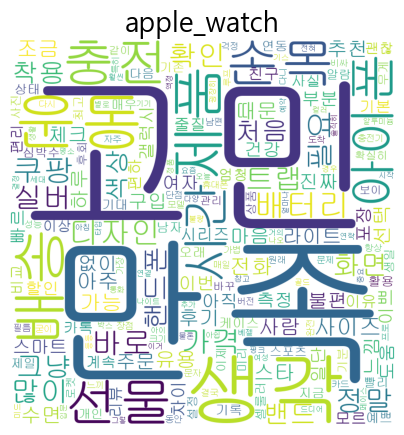

In [132]:
wc_apple = makeWordcloud(df_apple, 'apple_watch', stop_word)
wc_apple

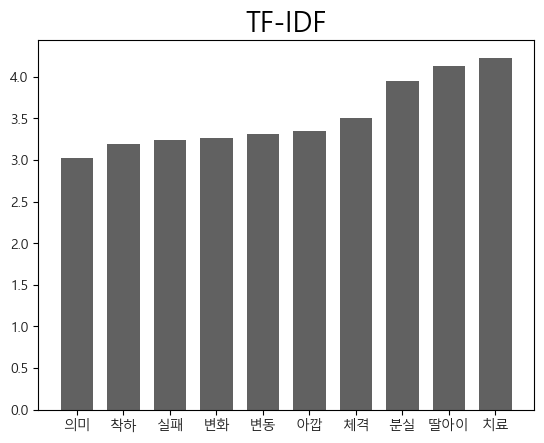

In [133]:
tfvec_tuple = tfvec(df_apple, 5, 2)
makeBar(tfvec_tuple[2], 'TF-IDF', tfvec_tuple[3])

In [134]:
pl_apple_tfvec = LDA(tfvec_tuple[1], tfvec_tuple[0], 3, 10)
pyLDAvis.save_html(pl_apple_tfvec, './model/lda_apple_cvec.html')
pyLDAvis.display(pl_apple_tfvec)

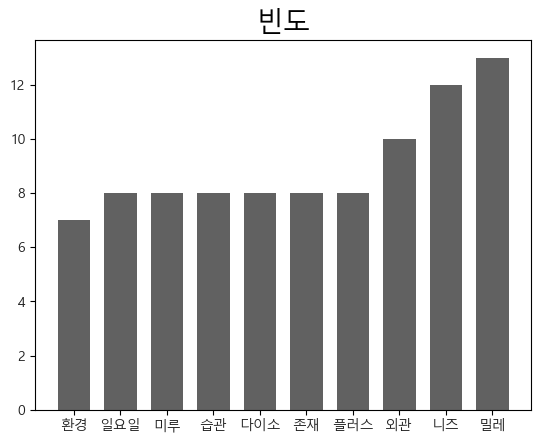

In [135]:
cvec_tuple = cvec(df_apple, 5, 2)
makeBar(cvec_tuple[2], '빈도', cvec_tuple[3])

In [136]:
pl_apple_cvec = LDA(cvec_tuple[1], cvec_tuple[0], 3, 10)
pyLDAvis.save_html(pl_apple_cvec, './model/lda_apple_cvec.html')
pyLDAvis.display(pl_apple_cvec)